# Importing necessary libraries

In [49]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import praw
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, f1_score
from scipy.sparse.linalg import svds
from surprise.model_selection import train_test_split as surprise_split

# Download required NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hemantrajsingh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Loading the Data

In [2]:
rating_path = "../data/u.data"
genre_path = "../data/u.genre"
movie_path = "../data/u.item"

rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
rating_df = pd.read_csv(rating_path, sep="\t", names=rating_columns, encoding="latin-1")

genre_df = pd.read_csv(genre_path, sep="|", header= None, names=["genre", "genre_id"], encoding= "latin-1")

movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + [f"Genre_{i}" for i in range(19)]
movie_df = pd.read_csv(movie_path, sep='|', names=movie_columns, encoding="latin-1")

# Data Preprocessing

In [3]:
# Format the date column
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'], errors='coerce')

In [5]:
genre_df.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [7]:
# Map Genres

genre_dict = dict(zip(genre_df['genre_id'], genre_df['genre']))
genre_columns = [col for col in movie_df.columns if 'Genre_' in col]

# Assign genres to movies:
def map_genres(row):
    return [genre_dict[idx] for idx, val in enumerate(row) if val == 1]

movie_df['genres'] = movie_df[genre_columns].apply(map_genres, axis=1)

## Data statistics

In [8]:
rating_df.shape

(100000, 4)

In [9]:
rating_df.info

<bound method DataFrame.info of        user_id  movie_id  rating  timestamp
0          196       242       3  881250949
1          186       302       3  891717742
2           22       377       1  878887116
3          244        51       2  880606923
4          166       346       1  886397596
...        ...       ...     ...        ...
99995      880       476       3  880175444
99996      716       204       5  879795543
99997      276      1090       1  874795795
99998       13       225       2  882399156
99999       12       203       3  879959583

[100000 rows x 4 columns]>

In [10]:
rating_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Genre statistics

In [11]:
genre_df.shape

(19, 2)

In [12]:
genre_df.info

<bound method DataFrame.info of           genre  genre_id
0       unknown         0
1        Action         1
2     Adventure         2
3     Animation         3
4    Children's         4
5        Comedy         5
6         Crime         6
7   Documentary         7
8         Drama         8
9       Fantasy         9
10    Film-Noir        10
11       Horror        11
12      Musical        12
13      Mystery        13
14      Romance        14
15       Sci-Fi        15
16     Thriller        16
17          War        17
18      Western        18>

In [13]:
genre_df.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


## Item Statistics

In [14]:
movie_df.shape

(1682, 25)

In [15]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            1682 non-null   int64         
 1   title               1682 non-null   object        
 2   release_date        1681 non-null   datetime64[ns]
 3   video_release_date  0 non-null      float64       
 4   imdb_url            1679 non-null   object        
 5   Genre_0             1682 non-null   int64         
 6   Genre_1             1682 non-null   int64         
 7   Genre_2             1682 non-null   int64         
 8   Genre_3             1682 non-null   int64         
 9   Genre_4             1682 non-null   int64         
 10  Genre_5             1682 non-null   int64         
 11  Genre_6             1682 non-null   int64         
 12  Genre_7             1682 non-null   int64         
 13  Genre_8             1682 non-null   int64       

In [16]:
movie_df.head()

,movie_id,title,release_date,video_release_date,imdb_url,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,...,Genre_10,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,genres
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,[Thriller]
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Action, Comedy, Drama]"
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[Crime, Drama, Thriller]"


# Merge Dataframes

In [17]:
# Merge the data with items
merged_data = pd.merge(rating_df, movie_df, on='movie_id')

In [18]:
merged_data.head()

,user_id,movie_id,rating,timestamp,title,release_date,video_release_date,imdb_url,Genre_0,Genre_1,...,Genre_10,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,genres
0,196,242,3,881250949,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,[Comedy]
1,186,302,3,891717742,L.A. Confidential (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,1,0,0,1,0,0,1,0,0,"[Crime, Film-Noir, Mystery, Thriller]"
2,22,377,1,878887116,Heavyweights (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,"[Children's, Comedy]"
3,244,51,2,880606923,Legends of the Fall (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,1,0,0,1,1,"[Drama, Romance, War, Western]"
4,166,346,1,886397596,Jackie Brown (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,"[Crime, Drama]"


# Exploratory Data Analysis (EDA)

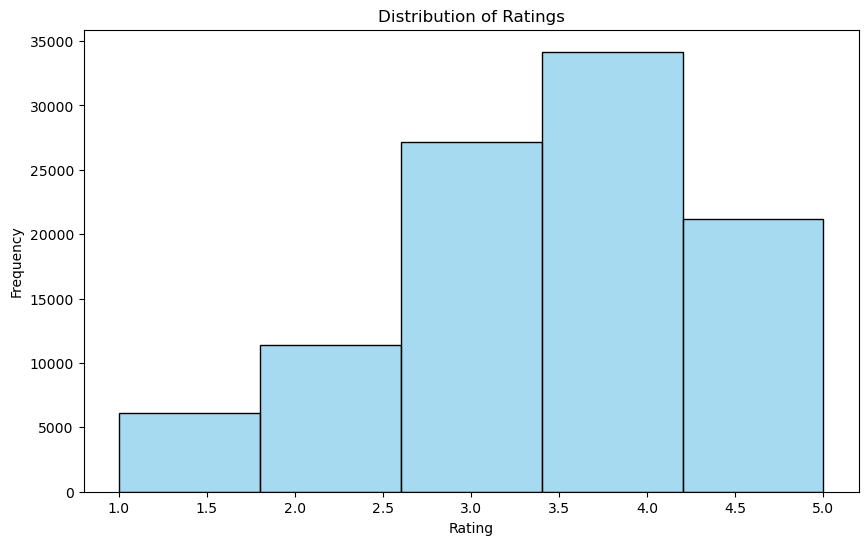

In [19]:
# Ratings Distribution

plt.figure(figsize=(10,6))
sns.histplot(merged_data['rating'], bins=5, kde = False, color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

/var/folders/qn/zrg5ms9n4mj424yzj3h57fh80000gn/T/ipykernel_15649/1904411148.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = most_rated.values, y= most_rated.index, palette='viridis')


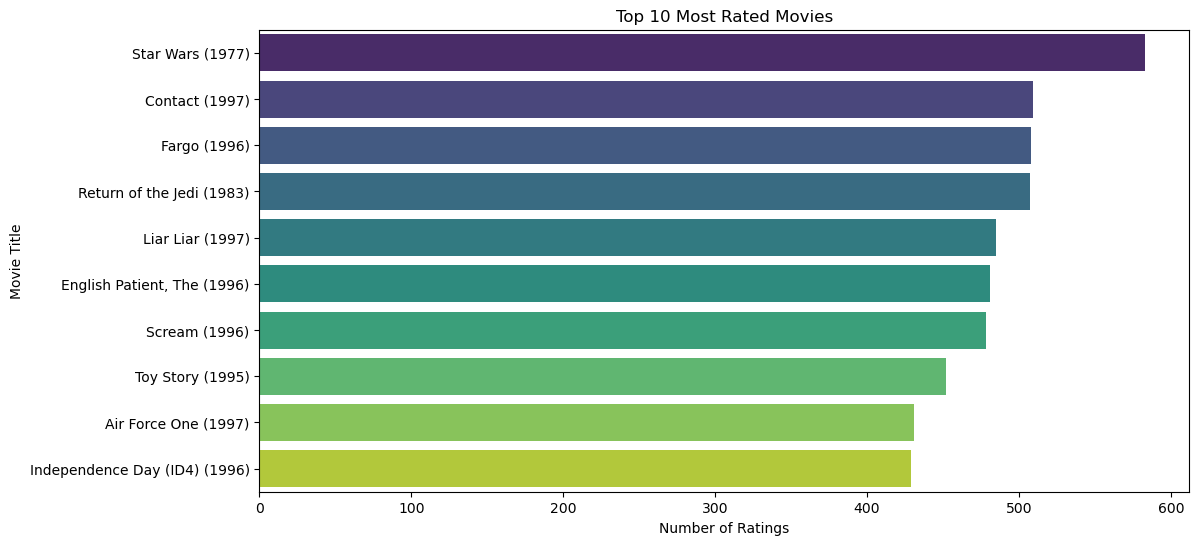

In [20]:
# Most Rated Movies

most_rated = merged_data['title'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x = most_rated.values, y= most_rated.index, palette='viridis')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()


In [21]:
merged_data.head()

,user_id,movie_id,rating,timestamp,title,release_date,video_release_date,imdb_url,Genre_0,Genre_1,...,Genre_10,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,genres
0,196,242,3,881250949,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,[Comedy]
1,186,302,3,891717742,L.A. Confidential (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,1,0,0,1,0,0,1,0,0,"[Crime, Film-Noir, Mystery, Thriller]"
2,22,377,1,878887116,Heavyweights (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,"[Children's, Comedy]"
3,244,51,2,880606923,Legends of the Fall (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,1,0,0,1,1,"[Drama, Romance, War, Western]"
4,166,346,1,886397596,Jackie Brown (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,"[Crime, Drama]"


/var/folders/qn/zrg5ms9n4mj424yzj3h57fh80000gn/T/ipykernel_15649/2236126459.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = genre_ratings.values, y = genre_ratings.index, palette='coolwarm')


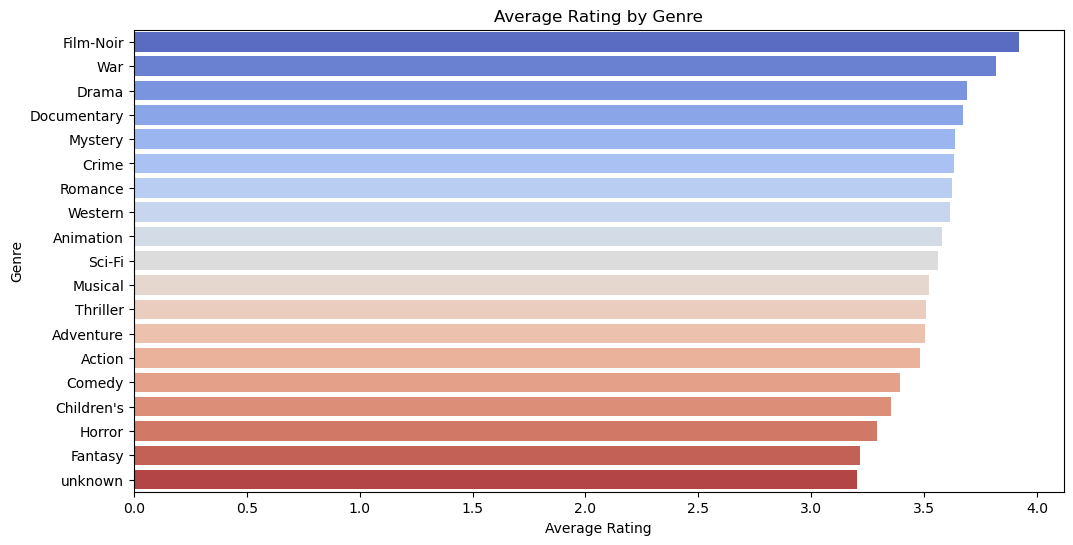

In [22]:
# Average Rating by Genre

genre_ratings = (
    merged_data.explode("genres")
    .groupby('genres')['rating']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize= (12,6))
sns.barplot(x = genre_ratings.values, y = genre_ratings.index, palette='coolwarm')
plt.title("Average Rating by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()

# Analaysis

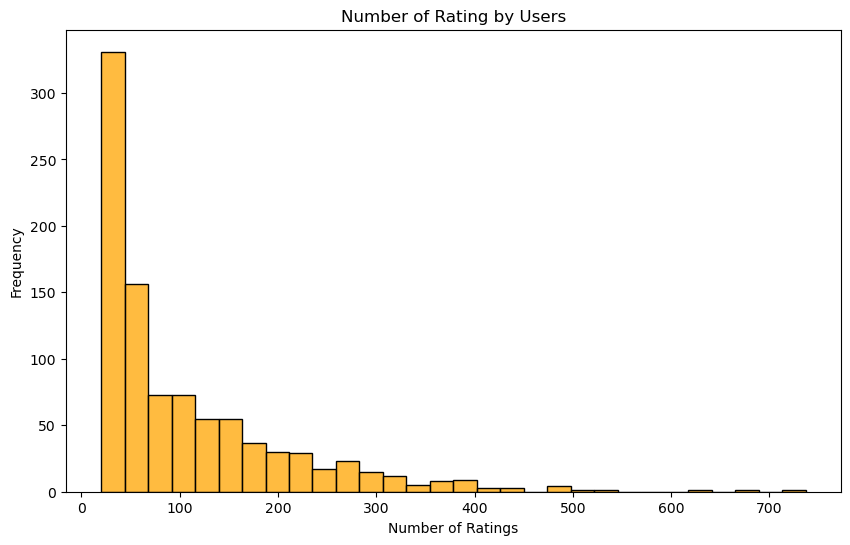

In [23]:
# User Rating Patterns

user_rating_count = merged_data.groupby('user_id')['rating'].count()
plt.figure(figsize= (10,6))
sns.histplot(user_rating_count, kde = False, bins = 30, color = 'orange')
plt.title("Number of Rating by Users")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

Average Ratings by Genre:
genres
Film-Noir      3.921523
War            3.815812
Drama          3.687379
Documentary    3.672823
Mystery        3.638132
Crime          3.632278
Romance        3.621705
Western        3.613269
Animation      3.576699
Sci-Fi         3.560723
Musical        3.521397
Thriller       3.509007
Adventure      3.503527
Action         3.480245
Comedy         3.394073
Children's     3.353244
Horror         3.290389
Fantasy        3.215237
unknown        3.200000
Name: rating, dtype: float64


/var/folders/qn/zrg5ms9n4mj424yzj3h57fh80000gn/T/ipykernel_15649/2790176937.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_rating_mean.values, y=genre_rating_mean.index, palette='coolwarm')


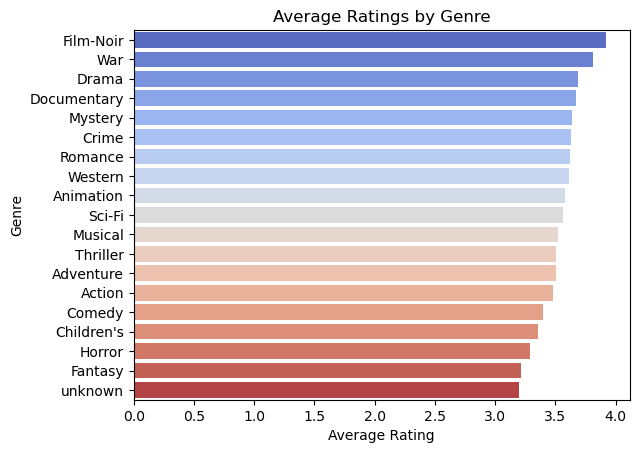

In [25]:
# Calculate the average rating per genre
genre_rating_mean = (
    merged_data.explode('genres')
    .groupby('genres')['rating']
    .mean()
    .sort_values(ascending=False)
)

# Display the result
print("Average Ratings by Genre:")
print(genre_rating_mean)

# Visualize the average ratings
sns.barplot(x=genre_rating_mean.values, y=genre_rating_mean.index, palette='coolwarm')
plt.title("Average Ratings by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


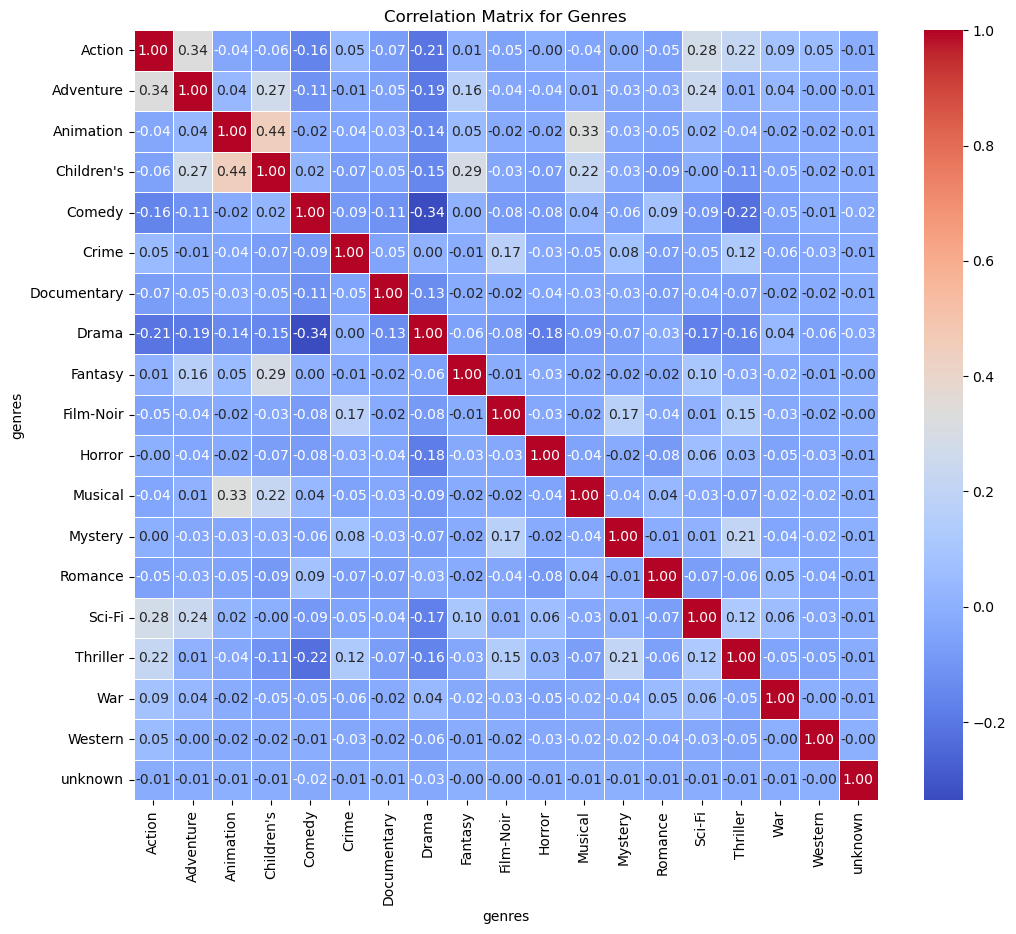

In [26]:
# Explode genres into binary columns
genre_matrix = merged_data.explode('genres').assign(value=1)
genre_matrix = (
    genre_matrix.pivot_table(index='title', columns='genres', values='value', fill_value=0)
)

# Compute the correlation matrix
genre_correlation_matrix = genre_matrix.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    genre_correlation_matrix,
    annot=True,
    cmap='coolwarm',  # Change this for different color schemes
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix for Genres")
plt.show()


In [28]:
# Save Processed Data:

merged_data.to_csv("../data/processed_movie_data.csv", index = False)

# Reddit Data Pull

In [31]:
movie_tags = movie_df['title'].tolist()
print(movie_tags)

['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', 'Get Shorty (1995)', 'Copycat (1995)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Twelve Monkeys (1995)', 'Babe (1995)', 'Dead Man Walking (1995)', 'Richard III (1995)', 'Seven (Se7en) (1995)', 'Usual Suspects, The (1995)', 'Mighty Aphrodite (1995)', 'Postino, Il (1994)', "Mr. Holland's Opus (1995)", 'French Twist (Gazon maudit) (1995)', 'From Dusk Till Dawn (1996)', 'White Balloon, The (1995)', "Antonia's Line (1995)", 'Angels and Insects (1995)', 'Muppet Treasure Island (1996)', 'Braveheart (1995)', 'Taxi Driver (1976)', 'Rumble in the Bronx (1995)', 'Birdcage, The (1996)', 'Brothers McMullen, The (1995)', 'Bad Boys (1995)', 'Apollo 13 (1995)', 'Batman Forever (1995)', 'Belle de jour (1967)', 'Crimson Tide (1995)', 'Crumb (1994)', 'Desperado (1995)', 'Doom Generation, The (1995)', 'Free Willy 2: The Adventure Home (1995)', 'Mad Love (1995)', 'Nadja (1994)', 'Net, The (1995)', 'Strange Days (1995)', 'To Wong F

In [32]:
reddit = praw.Reddit(client_id='lg6DiuKqFWpMcLyDfNrNfQ',
                        client_secret='7EKQJM-E-myaSWani7qthENaMcETcw',
                        user_agent='notebook:collaborative:hybrid:recommender')

In [99]:
def pull_reddit_posts(movie_tags):
    all_posts = []
    for tag in tqdm(movie_tags):
        subreddit = reddit.subreddit('all')
        for post in subreddit.search(tag):
            all_posts.append({'movie_tag': tag, 'title': post.title, 'post': post.selftext})
    return pd.DataFrame(all_posts)

In [100]:
reddit_df = pull_reddit_posts(movie_tags)
reddit_df.head()

100%|██████████| 1682/1682 [54:05<00:00,  1.93s/it] 


,movie_tag,title,post
0,Toy Story (1995),CGI difference between Toy Story (1995) and To...,
1,Toy Story (1995),"The phrase ""There's a snake in my boot!"" that ...",
2,Toy Story (1995),"In Coco (2017), a skeleton is wearing Sid's sh...",
3,Toy Story (1995),In Toy Story (1995) the characters sometimes b...,
4,Toy Story (1995),TIL The first Toy Story film (1995) required 8...,


In [103]:
reddit_df.shape

(136532, 3)

In [102]:
reddit_df.to_csv('../data/reddit_posts.csv', index=False)

# Reddit Sentiment Analysis

In [34]:
reddit_df = pd.read_csv('../data/reddit_posts_sentiment.csv')
reddit_df.head()

,movie_tag,title,post,combined_text,sentiment
0,Toy Story (1995),CGI difference between Toy Story (1995) and To...,NaN,CGI difference between Toy Story (1995) and To...,0.0000
1,Toy Story (1995),"The phrase ""There's a snake in my boot!"" that ...",NaN,"The phrase ""There's a snake in my boot!"" that ...",-0.5411
2,Toy Story (1995),"In Coco (2017), a skeleton is wearing Sid's sh...",NaN,"In Coco (2017), a skeleton is wearing Sid's sh...",0.0000
3,Toy Story (1995),In Toy Story (1995) the characters sometimes b...,NaN,In Toy Story (1995) the characters sometimes b...,0.0000
4,Toy Story (1995),TIL The first Toy Story film (1995) required 8...,NaN,TIL The first Toy Story film (1995) required 8...,0.0000


# Collaborative Filtering
## Matrix Factorization Model (SVD)

In [35]:
# Map user_id and movie_id to zero-based indexing
user_id_mapping = {id: idx for idx, id in enumerate(rating_df['user_id'].unique())}
movie_id_mapping = {id: idx for idx, id in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user_id_mapping)
rating_df['movie_id'] = rating_df['movie_id'].map(movie_id_mapping)

In [36]:
train_data, test_data = train_test_split(rating_df, test_size=0.2, random_state=42)

In [37]:
X_train = train_data[['user_id', 'movie_id']].values
y_train = train_data['rating'].values

X_test = test_data[['user_id', 'movie_id']].values
y_test = test_data['rating'].values

In [40]:
# Create DataLoader for PyTorch
train_dataset = TensorDataset(torch.tensor(X_train[:, 0]), torch.tensor(X_train[:, 1]), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test[:, 0]), torch.tensor(X_test[:, 1]), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [42]:
# Create user-item matrix
R_df = rating_df.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
R = R_df.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [45]:
# Perform SVD
U, sigma, Vt = svds(R_demeaned, k=50)  # k=50 is the number of latent factors
sigma = np.diag(sigma)

In [46]:
# Reconstruct the predicted ratings
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=R_df.columns)

In [47]:
# Calculate RMSE and MAE for Matrix Factorization model
def rmse(true_ratings, predicted_ratings):
    return np.sqrt(np.mean((true_ratings - predicted_ratings) ** 2))

def mae(true_ratings, predicted_ratings):
    return mean_absolute_error(true_ratings, predicted_ratings)

In [48]:
# Create test and train sets for evaluation
true_ratings = test_data['rating'].values
predicted_ratings_svd = [predicted_ratings_df.iloc[row['user_id'], row['movie_id']] for idx, row in test_data.iterrows()]

In [50]:
print(f'Collaborative Filtering RMSE: {rmse(true_ratings, predicted_ratings_svd):.4f}')
print(f'Collaborative Filtering MAE: {mae(true_ratings, predicted_ratings_svd):.4f}')

Collaborative Filtering RMSE: 1.8441
Collaborative Filtering MAE: 1.5300


# Hybrid Recommender System

In [51]:
class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(NeuralCollaborativeFiltering, self).__init__()
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, user, movie):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb], dim=-1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
# Initialize the model, loss function, and optimizer
num_users = len(user_id_mapping)
num_movies = len(movie_id_mapping)
embedding_dim = 30  # Hyperparameter to tune

In [54]:
model = NeuralCollaborativeFiltering(num_users, num_movies, embedding_dim)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
# Training the NCF model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for user, movie, rating in train_loader:
        optimizer.zero_grad()
        predicted_ratings = model(user, movie).squeeze()
        loss = loss_function(predicted_ratings, rating)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 1.3755
Epoch 2/20, Loss: 1.0637
Epoch 3/20, Loss: 0.9875
Epoch 4/20, Loss: 0.9482
Epoch 5/20, Loss: 0.9219
Epoch 6/20, Loss: 0.9024
Epoch 7/20, Loss: 0.8869
Epoch 8/20, Loss: 0.8785
Epoch 9/20, Loss: 0.8670
Epoch 10/20, Loss: 0.8584
Epoch 11/20, Loss: 0.8474
Epoch 12/20, Loss: 0.8396
Epoch 13/20, Loss: 0.8265
Epoch 14/20, Loss: 0.8191
Epoch 15/20, Loss: 0.8098
Epoch 16/20, Loss: 0.8025
Epoch 17/20, Loss: 0.7907
Epoch 18/20, Loss: 0.7829
Epoch 19/20, Loss: 0.7714
Epoch 20/20, Loss: 0.7624


In [56]:
# Evaluation of NCF model
def evaluate_model(model, test_loader):
    model.eval()
    all_true_ratings = []
    all_predicted_ratings = []
    with torch.no_grad():
        for user, movie, rating in test_loader:
            predicted_ratings = model(user, movie).squeeze()
            all_true_ratings.extend(rating.numpy())
            all_predicted_ratings.extend(predicted_ratings.numpy())
    all_true_ratings = np.array(all_true_ratings)
    all_predicted_ratings = np.array(all_predicted_ratings)
    test_rmse = np.sqrt(np.mean((all_true_ratings - all_predicted_ratings) ** 2))
    test_mae = mean_absolute_error(all_true_ratings, all_predicted_ratings)
    return test_rmse, test_mae

In [57]:
# Precision, Recall, and F1-Score (Example: Top-10 Recommendations)
def precision_at_k(true_ratings, predicted_ratings, k):
    top_k_predicted = np.argsort(predicted_ratings)[-k:]
    return np.mean([1 if true_ratings[i] in top_k_predicted else 0 for i in range(len(true_ratings))])

def recall_at_k(true_ratings, predicted_ratings, k):
    top_k_predicted = np.argsort(predicted_ratings)[-k:]
    return np.mean([1 if true_ratings[i] in top_k_predicted else 0 for i in range(len(true_ratings))])

In [58]:
# 5. **Hyperparameter Tuning**
embedding_sizes = [20, 30, 40, 50]
results = {}

In [60]:
for embedding_size in embedding_sizes:
    model = NeuralCollaborativeFiltering(num_users, num_movies, embedding_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        for user, movie, rating in train_loader:
            optimizer.zero_grad()
            predicted_ratings = model(user, movie).squeeze()
            loss = loss_function(predicted_ratings, rating)
            loss.backward()
            optimizer.step()
    
    test_rmse, test_mae = evaluate_model(model, test_loader)
    results[embedding_size] = (test_rmse, test_mae)

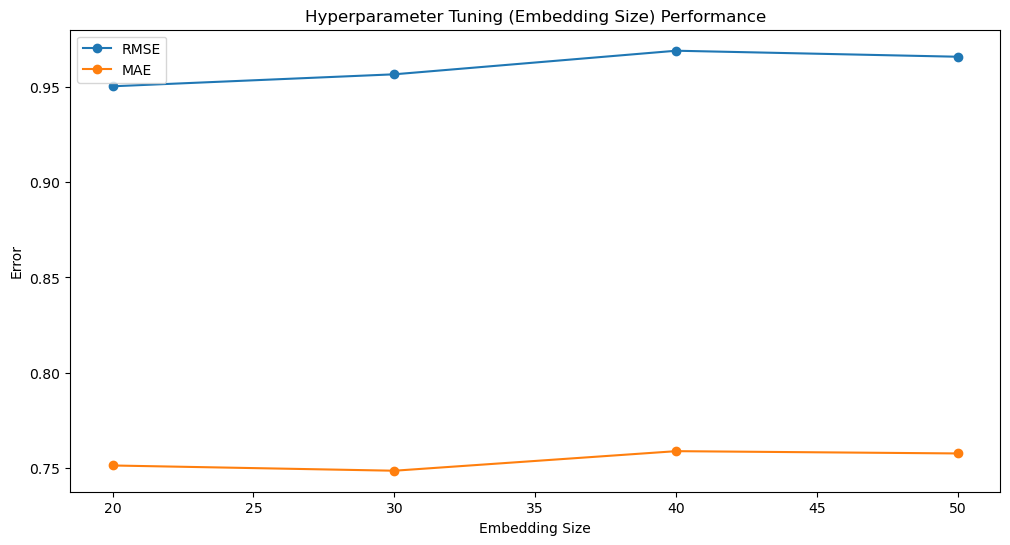

In [61]:
# Plot the results of hyperparameter tuning (embedding size)
embedding_size_list = list(results.keys())
rmse_values = [r[0] for r in results.values()]
mae_values = [r[1] for r in results.values()]

plt.figure(figsize=(12, 6))
plt.plot(embedding_size_list, rmse_values, label='RMSE', marker='o')
plt.plot(embedding_size_list, mae_values, label='MAE', marker='o')
plt.xlabel('Embedding Size')
plt.ylabel('Error')
plt.title('Hyperparameter Tuning (Embedding Size) Performance')
plt.legend()
plt.show()

# Comparison

## Compare the results of CF vs NCF

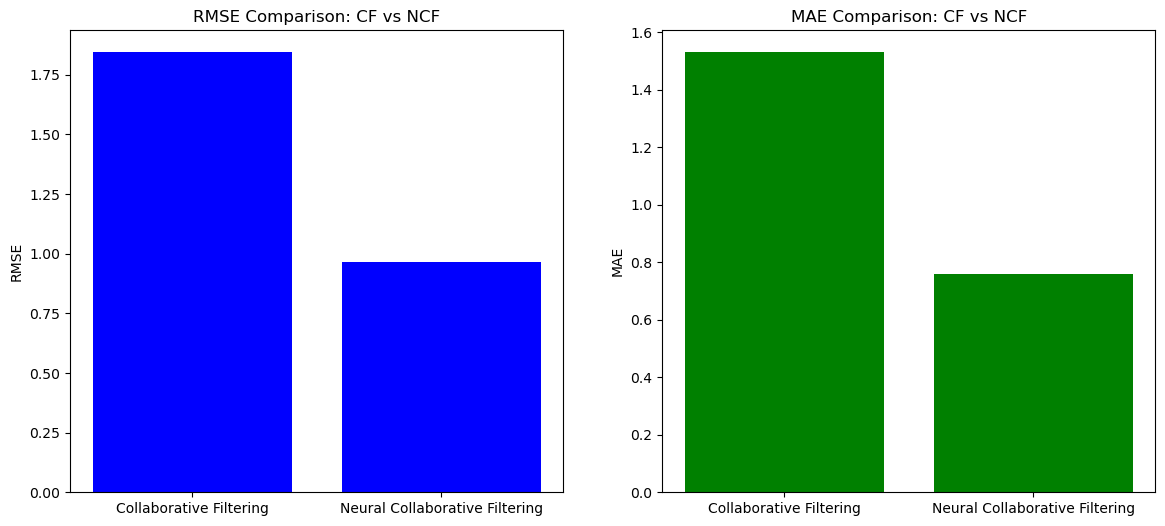

In [62]:
labels = ['Collaborative Filtering', 'Neural Collaborative Filtering']
rmse_values = [rmse(true_ratings, predicted_ratings_svd), test_rmse]
mae_values = [mae(true_ratings, predicted_ratings_svd), test_mae]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# RMSE Comparison
ax[0].bar(labels, rmse_values, color='blue')
ax[0].set_ylabel('RMSE')
ax[0].set_title('RMSE Comparison: CF vs NCF')

# MAE Comparison
ax[1].bar(labels, mae_values, color='green')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE Comparison: CF vs NCF')

plt.show()